# VQ-VAE-2 Latent Feature Extraction

Extract and visualize latent representations from all 3 hierarchical levels of the VQ-VAE-2 encoder (before quantization).

In [23]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
import os

# Import local modules
import vqvae
import datasets
from utils import load_data, transforms as get_transforms

# Settings
CHECKPOINT_PATH = "/home/ng24/projects/multiview-crl/results/ADNI_registered/vqvae-normal-logging-4/vqvae_model.pt"
DATA_DIR = "/data/natalia/ADNI_registered"
NUM_SAMPLES = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


In [24]:
# Load checkpoint settings to get model hyperparameters
settings_path = os.path.join(os.path.dirname(CHECKPOINT_PATH), "settings.json")
with open(settings_path, "r") as f:
    settings = json.load(f)

print("Model settings:")
print(f"  Hidden channels: {settings['vqvae_hidden_channels']}")
print(f"  Res channels: {settings['vqvae_res_channels']}")
print(f"  Num levels: {settings['vqvae_nb_levels']}")
print(f"  Embed dim: {settings['vqvae_embed_dim']}")
print(f"  Codebook entries: {settings['vqvae_nb_entries']}")
print(f"  Scaling rates: {settings['vqvae_scaling_rates']}")

Model settings:
  Hidden channels: 48
  Res channels: 32
  Num levels: 3
  Embed dim: 24
  Codebook entries: 384
  Scaling rates: [2, 2, 2]


In [25]:
# Build VQ-VAE-2 model with same architecture
model = vqvae.VQVAE(
    in_channels=1,
    hidden_channels=settings['vqvae_hidden_channels'],
    res_channels=settings['vqvae_res_channels'],
    nb_res_layers=settings.get('vqvae_nb_res_layers', 2),  # Support both old and new checkpoints
    nb_levels=settings['vqvae_nb_levels'],
    embed_dim=settings['vqvae_embed_dim'],
    nb_entries=settings['vqvae_nb_entries'],
    scaling_rates=settings['vqvae_scaling_rates'],
)

# Wrap in DataParallel (to match checkpoint structure)
model = torch.nn.DataParallel(model, device_ids=[0])

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

# Handle checkpoint format: if old checkpoint has "blocks", convert to "stack"
state_dict = checkpoint['encoders']
new_state_dict = {}

for key, val in state_dict.items():
    # Replace "blocks" with "stack" in the key names (for old checkpoints)
    new_key = key.replace('.blocks.', '.stack.')
    new_state_dict[new_key] = val

# Try loading with the converted state dict
try:
    model.load_state_dict(new_state_dict)
    print("✓ Loaded checkpoint with format conversion (.blocks → .stack)")
except RuntimeError as e:
    # If conversion failed, try loading the original
    print(f"Conversion failed: {str(e)[:200]}...")
    print("Attempting to load original state dict...")
    try:
        model.load_state_dict(state_dict)
        print("✓ Loaded checkpoint with original format")
    except RuntimeError as e2:
        print(f"Failed to load checkpoint: {str(e2)[:500]}")
        raise

model.to(DEVICE)
model.eval()

print(f"✓ Model loaded from step {checkpoint['step']}")
print(f"  Total params: {sum(p.numel() for p in model.parameters()):,}")

✓ Loaded checkpoint with format conversion (.blocks → .stack)
✓ Model loaded from step 10001
  Total params: 1,795,767


In [27]:
# Load dataset
csv_path = '/home/ng24/projects/nmpevqvae/labels_cleaned_3class.csv'
df = pd.read_csv(csv_path)
label_values = sorted(df['Group'].unique())
label_map = {v: i for i, v in enumerate(label_values)}
print(f"Labels: {label_map}")

items, missing = load_data(df, DATA_DIR, label_map)
print(f"Loaded {len(items)} samples, {missing} missing files")

# ============================================================
# CONFIGURATION: Choose resampling mode
# ============================================================
# Options:
#   - "original": Keep original image size (no resampling, ~182x218x182 for 1mm)
#   - "2mm": Downsample to 2mm isotropic spacing (~91x109x91)
RESAMPLE_MODE = "original"  # Change this to "original" to keep full resolution
# ============================================================

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ResizeWithPadOrCropd, NormalizeIntensityd, ToTensord
)

# Import custom transforms from utils
from utils import CreateBrainMaskd, ApplyBrainMaskd

if RESAMPLE_MODE == "original":
    print("Using ORIGINAL resolution (no downsampling)")
    # Original 1mm resolution - just normalize and orient
    val_transforms = Compose([
        LoadImaged(keys=['image_t1', 'image_t2']),
        EnsureChannelFirstd(keys=['image_t1', 'image_t2'], channel_dim="no_channel"),
        CreateBrainMaskd(keys=['image_t1', 'image_t2'], mask_keys=['mask_t1', 'mask_t2']),
        Orientationd(keys=['image_t1', 'image_t2', 'mask_t1', 'mask_t2'], axcodes="RAS"),
        NormalizeIntensityd(keys=['image_t1', 'image_t2'], nonzero=True, channel_wise=True),
        ApplyBrainMaskd(keys=['image_t1', 'image_t2'], mask_keys=['mask_t1', 'mask_t2'], threshold=0.5),
        ToTensord(keys=['image_t1', 'image_t2']),  # Removed 'label' - not in data_dict
    ])
elif RESAMPLE_MODE == "2mm":
    print("Using 2mm isotropic downsampling (91x109x91)")
    spatial_size = (91, 109, 91)
    val_transforms = Compose([
        LoadImaged(keys=['image_t1', 'image_t2']),
        EnsureChannelFirstd(keys=['image_t1', 'image_t2'], channel_dim="no_channel"),
        CreateBrainMaskd(keys=['image_t1', 'image_t2'], mask_keys=['mask_t1', 'mask_t2']),
        Spacingd(keys=['image_t1', 'image_t2'], pixdim=(2.0, 2.0, 2.0), mode="bilinear"),
        Spacingd(keys=['mask_t1', 'mask_t2'], pixdim=(2.0, 2.0, 2.0), mode="nearest"),
        Orientationd(keys=['image_t1', 'image_t2', 'mask_t1', 'mask_t2'], axcodes="RAS"),
        ResizeWithPadOrCropd(keys=['image_t1', 'image_t2', 'mask_t1', 'mask_t2'], spatial_size=spatial_size),
        NormalizeIntensityd(keys=['image_t1', 'image_t2'], nonzero=True, channel_wise=True),
        ApplyBrainMaskd(keys=['image_t1', 'image_t2'], mask_keys=['mask_t1', 'mask_t2'], threshold=0.5),
        ToTensord(keys=['image_t1', 'image_t2']),  # Removed 'label' - not in data_dict
    ])
else:
    raise ValueError(f"Unknown RESAMPLE_MODE: {RESAMPLE_MODE}. Use 'original' or '2mm'")

# Limit to NUM_SAMPLES
items = items[:NUM_SAMPLES]
print(f"Using {len(items)} samples for latent extraction")

Labels: {'AD': 0, 'CN': 1, 'MCI': 2}
Loaded 1608 samples, ['381_S_10551', '381_S_10511', '127_S_6357', '127_S_0259', '114_S_10841', '114_S_10380', '099_S_6632', '035_S_10068', '021_S_6890', '019_S_5019', '019_S_5012', '019_S_4252'] missing files
Using ORIGINAL resolution (no downsampling)
Using 100 samples for latent extraction


monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


In [28]:
def extract_encoder_features(model, image):
    """
    Extract encoder features at all hierarchical levels BEFORE quantization.
    
    Args:
        model: VQ-VAE-2 model
        image: Input tensor (1, 1, D, H, W)
    
    Returns:
        encoder_outputs: List of tensors, one per level (before VQ)
        labels for each level with shapes
    """
    model.eval()
    with torch.no_grad():
        # Access the underlying model (unwrap DataParallel)
        vqvae_module = model.module if hasattr(model, 'module') else model
        
        # Run through encoders only (before quantization)
        encoder_outputs = []
        x = image
        for i, enc in enumerate(vqvae_module.encoders):
            if len(encoder_outputs):
                x = enc(encoder_outputs[-1])
            else:
                x = enc(x)
            encoder_outputs.append(x)
        
        return encoder_outputs

# Test on first image
test_item = items[0]
data_dict = {'image_t1': test_item['image'], 'image_t2': test_item['z_image']}
transformed = val_transforms(data_dict)
test_img = transformed['image_t1'].unsqueeze(0).to(DEVICE)

test_outputs = extract_encoder_features(model, test_img)
print("Encoder output shapes (before quantization):")
for i, out in enumerate(test_outputs):
    print(f"  Level {i}: {out.shape} → {out.numel()} elements")

Encoder output shapes (before quantization):
  Level 0: torch.Size([1, 48, 90, 108, 90]) → 41990400 elements
  Level 1: torch.Size([1, 48, 45, 54, 45]) → 5248800 elements
  Level 2: torch.Size([1, 48, 22, 27, 22]) → 627264 elements


In [29]:
# Extract features for all samples
all_features = {f'level_{i}': [] for i in range(settings['vqvae_nb_levels'])}
all_labels = []
all_modalities = []  # Track T1 vs T2

print(f"Extracting latent features from {len(items)} samples...")

for idx, item in enumerate(items):
    if idx % 20 == 0:
        print(f"  Processing {idx}/{len(items)}...")
    
    # Apply transforms
    data_dict = {'image_t1': item['image'], 'image_t2': item['z_image']}
    transformed = val_transforms(data_dict)
    
    # Process T1 (view 1)
    img_t1 = transformed['image_t1'].unsqueeze(0).to(DEVICE)
    enc_outputs_t1 = extract_encoder_features(model, img_t1)
    
    for level_idx, out in enumerate(enc_outputs_t1):
        # Global average pooling to get (C,) vector per image
        pooled = out.mean(dim=[2, 3, 4]).cpu().numpy().squeeze()
        all_features[f'level_{level_idx}'].append(pooled)
    
    all_labels.append(item['label'])
    all_modalities.append('T1')
    
    # Process T2 (view 2)
    img_t2 = transformed['image_t2'].unsqueeze(0).to(DEVICE)
    enc_outputs_t2 = extract_encoder_features(model, img_t2)
    
    for level_idx, out in enumerate(enc_outputs_t2):
        pooled = out.mean(dim=[2, 3, 4]).cpu().numpy().squeeze()
        all_features[f'level_{level_idx}'].append(pooled)
    
    all_labels.append(item['label'])
    all_modalities.append('T2')

# Convert to numpy arrays
for key in all_features:
    all_features[key] = np.array(all_features[key])
all_labels = np.array(all_labels)
all_modalities = np.array(all_modalities)

print(f"\n✓ Feature extraction complete!")
for key, val in all_features.items():
    print(f"  {key}: {val.shape}")

Extracting latent features from 100 samples...
  Processing 0/100...
  Processing 20/100...
  Processing 20/100...
  Processing 40/100...
  Processing 40/100...
  Processing 60/100...
  Processing 60/100...
  Processing 80/100...
  Processing 80/100...

✓ Feature extraction complete!
  level_0: (200, 48)
  level_1: (200, 48)
  level_2: (200, 48)

✓ Feature extraction complete!
  level_0: (200, 48)
  level_1: (200, 48)
  level_2: (200, 48)


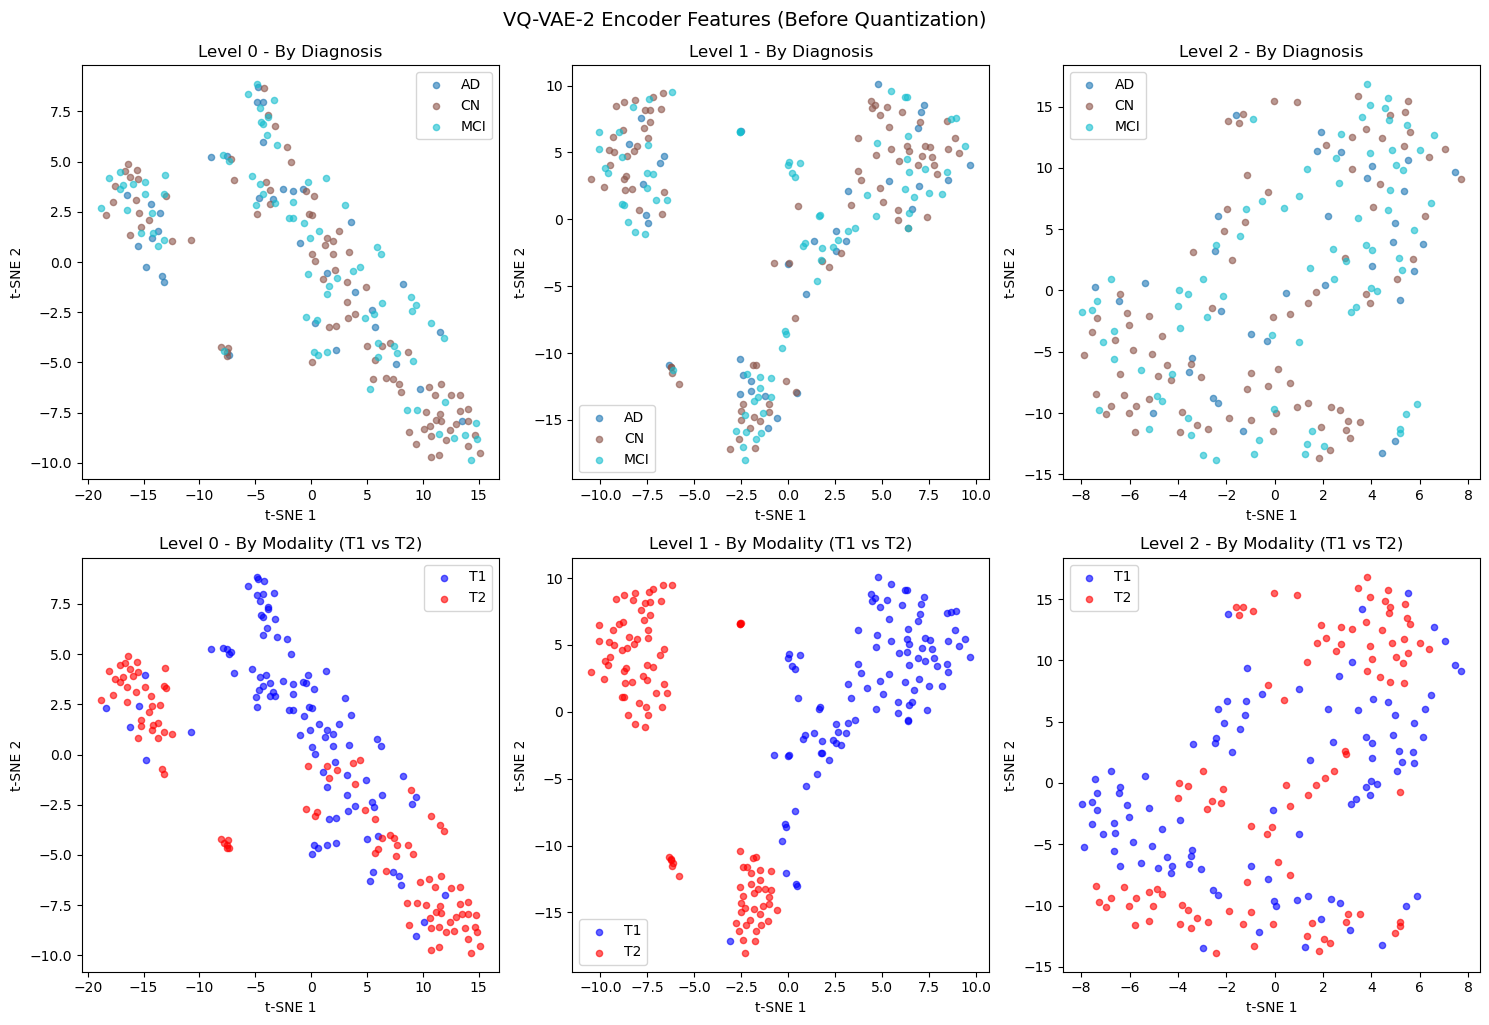

✓ Saved to latent_features_tsne_logging.png


In [30]:
# Visualize with t-SNE for each level
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Label names for coloring
label_names = {v: k for k, v in label_map.items()}
colors_by_label = plt.cm.tab10(np.linspace(0, 1, len(label_map)))

for level_idx in range(settings['vqvae_nb_levels']):
    features = all_features[f'level_{level_idx}']
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    features_2d = tsne.fit_transform(features)
    
    # Plot by diagnosis label
    ax1 = axes[0, level_idx]
    for label_idx, label_name in label_names.items():
        mask = all_labels == label_idx
        ax1.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   c=[colors_by_label[label_idx]], label=label_name, alpha=0.6, s=20)
    ax1.set_title(f'Level {level_idx} - By Diagnosis')
    ax1.legend()
    ax1.set_xlabel('t-SNE 1')
    ax1.set_ylabel('t-SNE 2')
    
    # Plot by modality (T1 vs T2)
    ax2 = axes[1, level_idx]
    for mod, color in [('T1', 'blue'), ('T2', 'red')]:
        mask = all_modalities == mod
        ax2.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   c=color, label=mod, alpha=0.6, s=20)
    ax2.set_title(f'Level {level_idx} - By Modality (T1 vs T2)')
    ax2.legend()
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.suptitle('VQ-VAE-2 Encoder Features (Before Quantization)', y=1.02, fontsize=14)
plt.savefig('latent_features_tsne_logging.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to latent_features_tsne_logging.png")

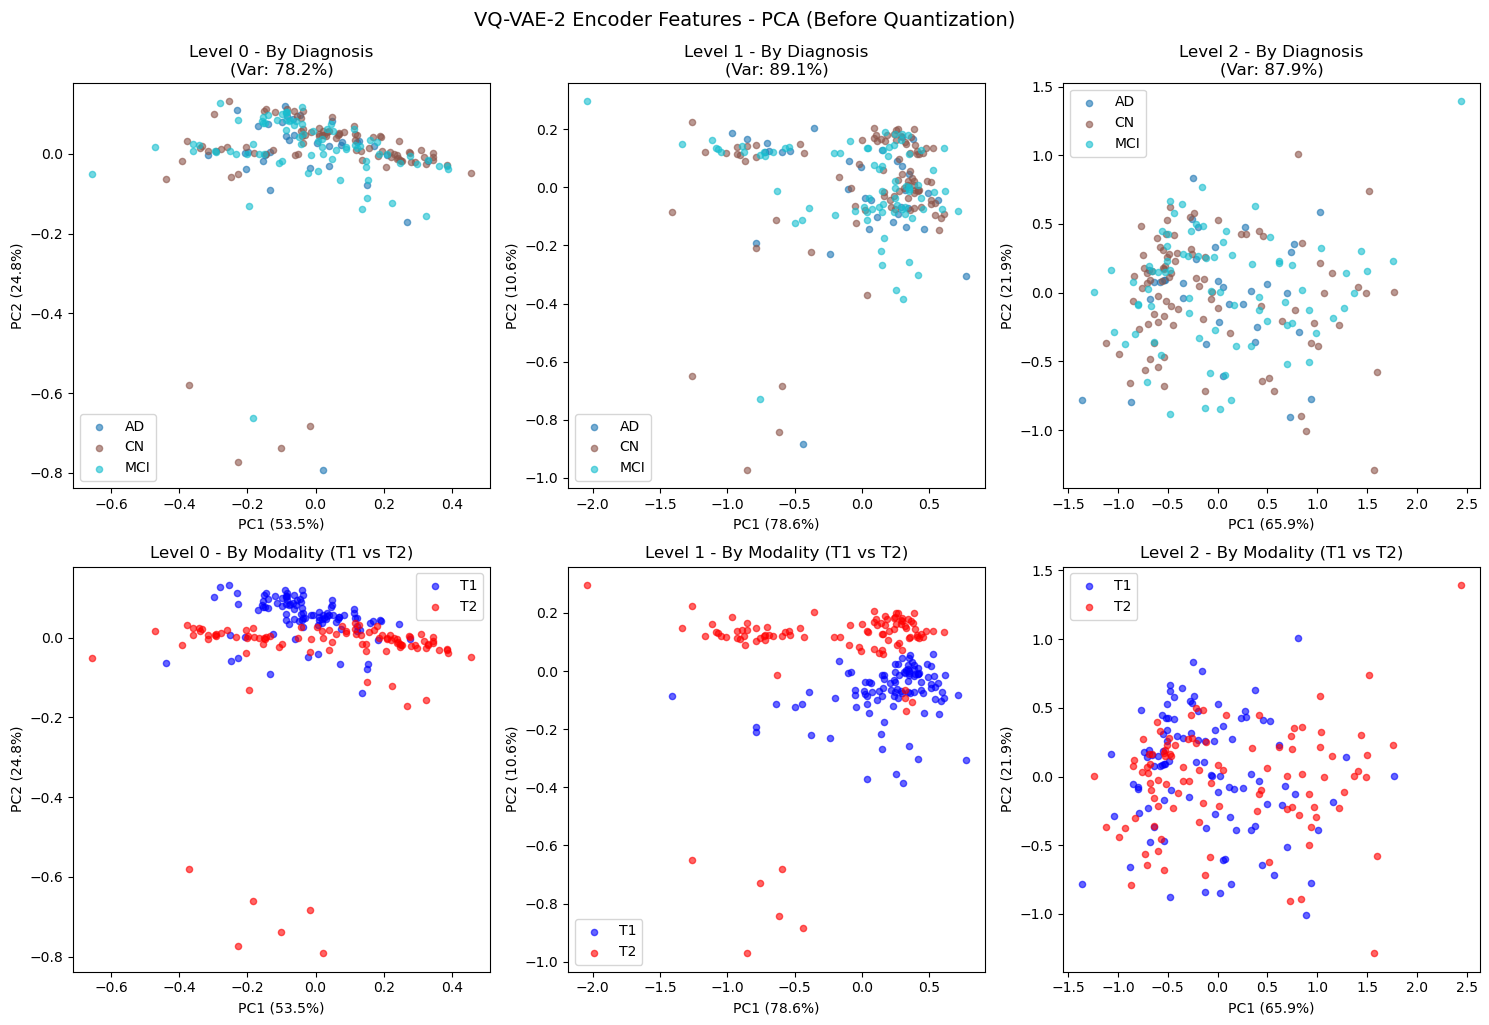

✓ Saved to latent_features_pca_logging.png


In [31]:
# Alternative: PCA visualization (faster, deterministic)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for level_idx in range(settings['vqvae_nb_levels']):
    features = all_features[f'level_{level_idx}']
    
    # PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    # Plot by diagnosis label
    ax1 = axes[0, level_idx]
    for label_idx, label_name in label_names.items():
        mask = all_labels == label_idx
        ax1.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   c=[colors_by_label[label_idx]], label=label_name, alpha=0.6, s=20)
    ax1.set_title(f'Level {level_idx} - By Diagnosis\n(Var: {pca.explained_variance_ratio_.sum()*100:.1f}%)')
    ax1.legend()
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    
    # Plot by modality (T1 vs T2)
    ax2 = axes[1, level_idx]
    for mod, color in [('T1', 'blue'), ('T2', 'red')]:
        mask = all_modalities == mod
        ax2.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   c=color, label=mod, alpha=0.6, s=20)
    ax2.set_title(f'Level {level_idx} - By Modality (T1 vs T2)')
    ax2.legend()
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

plt.tight_layout()
plt.suptitle('VQ-VAE-2 Encoder Features - PCA (Before Quantization)', y=1.02, fontsize=14)
plt.savefig('latent_features_pca_logging.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to latent_features_pca_logging.png")

In [15]:
# Feature statistics per level
print("=" * 60)
print("Feature Statistics by Level (Before Quantization)")
print("=" * 60)

for level_idx in range(settings['vqvae_nb_levels']):
    features = all_features[f'level_{level_idx}']
    print(f"\nLevel {level_idx}:")
    print(f"  Shape: {features.shape}")
    print(f"  Mean: {features.mean():.4f}")
    print(f"  Std: {features.std():.4f}")
    print(f"  Min: {features.min():.4f}")
    print(f"  Max: {features.max():.4f}")
    
    # Check if T1 and T2 are separable
    t1_features = features[all_modalities == 'T1']
    t2_features = features[all_modalities == 'T2']
    
    # Compute average distance between T1 and T2 for same subject
    paired_distances = np.linalg.norm(t1_features - t2_features, axis=1)
    print(f"  T1-T2 paired distance (mean): {paired_distances.mean():.4f}")

Feature Statistics by Level (Before Quantization)

Level 0:
  Shape: (200, 64)
  Mean: -0.0108
  Std: 0.0461
  Min: -0.1604
  Max: 0.1662
  T1-T2 paired distance (mean): 0.1646

Level 1:
  Shape: (200, 64)
  Mean: -0.0069
  Std: 0.1099
  Min: -0.5963
  Max: 0.7304
  T1-T2 paired distance (mean): 0.6678

Level 2:
  Shape: (200, 64)
  Mean: 0.0159
  Std: 0.1988
  Min: -0.7103
  Max: 0.6423
  T1-T2 paired distance (mean): 0.6463


In [16]:
# Save extracted features for later analysis
save_dict = {
    'features_level_0': all_features['level_0'],
    'features_level_1': all_features['level_1'],
    'features_level_2': all_features['level_2'],
    'labels': all_labels,
    'modalities': all_modalities,
    'label_map': label_map,
    'checkpoint_step': checkpoint['step'],
}

np.savez('extracted_latents.npz', **save_dict)
print("✓ Saved features to extracted_latents.npz")
print(f"  Level 0: {all_features['level_0'].shape}")
print(f"  Level 1: {all_features['level_1'].shape}")
print(f"  Level 2: {all_features['level_2'].shape}")

✓ Saved features to extracted_latents.npz
  Level 0: (200, 64)
  Level 1: (200, 64)
  Level 2: (200, 64)
